# Data
Download the IMDB reviews if its not already in the local cache.
Load from the local cache and split to train and test sets.

In [1]:
import os
import ssl
from keras.utils import get_file
try:
    from notebooks.data import load_imdb
except ModuleNotFoundError:
    from data import load_imdb

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context
    
zip_file = get_file('aclImdb.zip', origin='http://mng.bz/0tIo', extract=True)
imdb_dir = zip_file.replace('.zip', '')
(train_texts, train_labels), (test_texts, test_labels) = load_imdb(imdb_dir)

print('An example from the reviews:')
print('============================')
print(f'Text : {train_texts[0][:200]}...')
print(f'Label: {train_labels[0]}')

Using TensorFlow backend.


An example from the reviews:
Text : If you are expecting to see a lot in the bath of Alt&#305;oklar, as it is promised by the tag line, you will be very disappointed to see that the movie consists of nothing but the populist style of Al...
Label: neg


# Prepare Data
Initialize a `SentCharVectorizer`. The vectorizer will be fitted on the 
`train_texts`. We will use a set a simple sentence tokenizer and no word 
tokenizer, so the words will be splitted on spaces. The vocabulary is 
restricted to the provided characters.

In [2]:
from keras_nlp.preprocessing import sent_tokenize
from keras_nlp import SentCharVectorizer

sent_char_vectorizer = SentCharVectorizer(
    sent_tokenize, characters='abcdefghijklmnopqrstuvwxyz', oov_token='#')
sent_char_vectorizer.fit_on_texts(train_texts)
# The vectorizer's number of tokens num_words + PAD + OOV token
print(f'Vectorizer number of tokens: {sent_char_vectorizer.num_tokens}')

19-Dec-06 23:49:01 [INFO    ] [SentCharVectorizer] - Creating vocabulary.


Vectorizer number of tokens: 28


## Vectorize Data
We apply the fitted vectorizer to the train and test texts. 
Also we have to set the `max_sentences` per text and `max_words` per sentence
and `max_characters` per word. 

In [3]:
max_sentences, max_tokens, max_characters = 10, 15, 30
X_train = sent_char_vectorizer.texts_to_vectors(
    train_texts, shape=(max_sentences, max_tokens, max_characters))

19-Dec-06 23:49:01 [INFO    ] [SentCharVectorizer] - Converting texts to vectors.
19-Dec-06 23:49:15 [INFO    ] [SentCharVectorizer] - Reshaping vectors to shape (10, 15, 30).


25000/25000 [==============================] - 25s 1ms/step

**Attention**: We *must* pass the same number `max_sentences` per text and 
`max_words` per sentence and `max_characters` per word. of `max_tokens` when 
converting different text sets. If we don't, then it is almost certain that 
the results will have different numbers of columns because the set are likely 
to have different number of tokens.

In [4]:
X_test = sent_char_vectorizer.texts_to_vectors(
    test_texts, shape=(max_sentences, max_tokens, max_characters))

19-Dec-06 23:49:41 [INFO    ] [SentCharVectorizer] - Converting texts to vectors.
19-Dec-06 23:49:54 [INFO    ] [SentCharVectorizer] - Reshaping vectors to shape (10, 15, 30).


25000/25000 [==============================] - 25s 1000us/step

## Decode Data
Print a decoded fragment of an encoded text as an example.

In [5]:
decoded = sent_char_vectorizer.vectors_to_texts(X_test[:1])
print(decoded[0][2])

19-Dec-06 23:50:20 [INFO    ] [SentCharVectorizer] - Converting vectors to texts.


10/10 [==============================] - 0s 288us/step
[['w', 'h', 'a', 't'], ['a'], ['n', 'i', 'c', 'e'], ['a', 'n', 'd'], ['k', 'i', 'n', 'd'], ['m', 'a', 'n']]


## Encode Labels
The labels are strings ('pos' / 'neg'). We will convert them to numbers.

In [6]:
from sklearn.preprocessing import label_binarize

y_train = label_binarize(train_labels, classes=['neg', 'pos'])
y_test = label_binarize(test_labels, classes=['neg', 'pos'])

## Keep a Validation Set

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify=y_train, shuffle=True, random_state=44)

print(f'X_train: {X_train.shape}')
print(f'X_dev  : {X_val.shape}')
print(f'X_test : {X_test.shape}')

X_train: (18750, 10, 15, 30)
X_dev  : (6250, 10, 15, 30)
X_test : (25000, 10, 15, 30)


# Neural Network
Here we define a toy network for demonstration purpose.
The model has two layers. The first encodes the characters of the words of a 
sentence providing sentence vectors. The second encodes the sentence
vectors to a document vector.

## Characters Encoder Model

In [8]:
from keras.models import Model
from keras.layers import (Input, Embedding, Flatten, Dense, Bidirectional,
                          LSTM, TimeDistributed, Dropout)

rnn_params = dict(dropout=0.2, return_sequences=True, recurrent_dropout=0.2)

chars_input = Input(
    shape=(
        max_tokens,
        max_characters,
    ), name='Input', dtype='int32')
chars_embeddings = TimeDistributed(
    Embedding(
        input_dim=sent_char_vectorizer.num_tokens,
        output_dim=20,
        input_length=max_characters,
        mask_zero=False,
        trainable=True),
    name='Embeddings')(chars_input)
x = Dropout(0.4, name='Input_Dropout')(chars_embeddings)
x = Flatten(name='Flatten')(x)
x = Dropout(0.4, name='Dropout')(x)
char_model = Model(chars_input, x)

print(char_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 15, 30)            0         
_________________________________________________________________
Embeddings (TimeDistributed) (None, 15, 30, 20)        560       
_________________________________________________________________
Input_Dropout (Dropout)      (None, 15, 30, 20)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 9000)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 9000)              0         
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________
None


## Sentence Encoder Model

In [9]:
sent_input = Input(
    shape=(max_sentences, max_tokens, max_characters), dtype='int32', name='Sent_Input')
sent_input_over_word_model = TimeDistributed(
    char_model, name='Word_Model')(sent_input)
sent_encoder = Bidirectional(
    LSTM(100, **rnn_params), name='Sents_Encoder')(sent_input_over_word_model)
x = Dropout(0.3, name='Dropout')(sent_encoder)
x = Flatten(name='Flatten')(x)
predictions = Dense(1, activation='sigmoid', name='Predictions')(x)
model = Model(sent_input, predictions)

print(model.summary(90))

__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
Sent_Input (InputLayer)                 (None, 10, 15, 30)                  0             
__________________________________________________________________________________________
Word_Model (TimeDistributed)            (None, 10, 9000)                    560           
__________________________________________________________________________________________
Sents_Encoder (Bidirectional)           (None, 10, 200)                     7280800       
__________________________________________________________________________________________
Dropout (Dropout)                       (None, 10, 200)                     0             
__________________________________________________________________________________________
Flatten (Flatten)                       (None, 2000)                        0             

## Train Model

In [10]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train,
                    y_train, 
                    batch_size=50, 
                    epochs=5, 
                    validation_data=(X_val, y_val))

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 31s 2ms/step - loss: 0.6934 - acc: 0.5340 - val_loss: 0.6523 - val_acc: 0.6205

## Model Evaluation

In [11]:
scores = model.evaluate(X_test, y_test)
print(f'Evaluation accuracy: {100*scores[1]:.2f}%')

25000/25000 [==============================] - 17s 661us/step

# Plot Accuracy and Loss

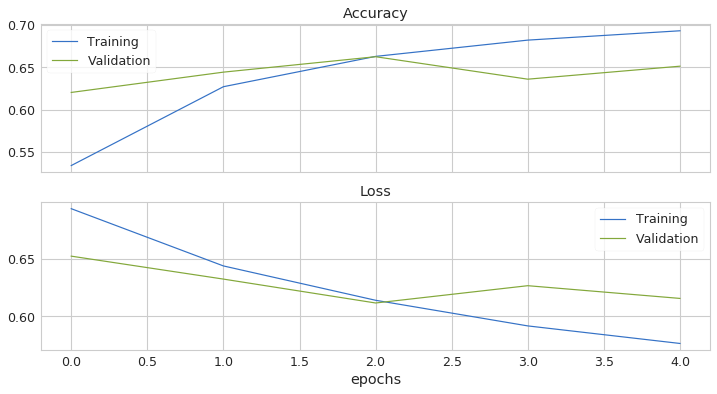

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
ax1.plot(history.epoch, history.history['acc'], label='Training')
ax1.plot(history.epoch, history.history['val_acc'], label='Validation')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(history.epoch, history.history['loss'], label='Training')
ax2.plot(history.epoch, history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.legend()

plt.show()